Epoch [1/10], Train Loss: 0.0056, Val Loss: 0.0011
Epoch [2/10], Train Loss: 0.0012, Val Loss: 0.0011
Epoch [3/10], Train Loss: 0.0010, Val Loss: 0.0014
Epoch [4/10], Train Loss: 0.0008, Val Loss: 0.0009
Epoch [5/10], Train Loss: 0.0007, Val Loss: 0.0014
Epoch [6/10], Train Loss: 0.0007, Val Loss: 0.0010
Epoch [7/10], Train Loss: 0.0006, Val Loss: 0.0009
Epoch [8/10], Train Loss: 0.0006, Val Loss: 0.0012
Epoch [9/10], Train Loss: 0.0005, Val Loss: 0.0010
Epoch [10/10], Train Loss: 0.0005, Val Loss: 0.0010


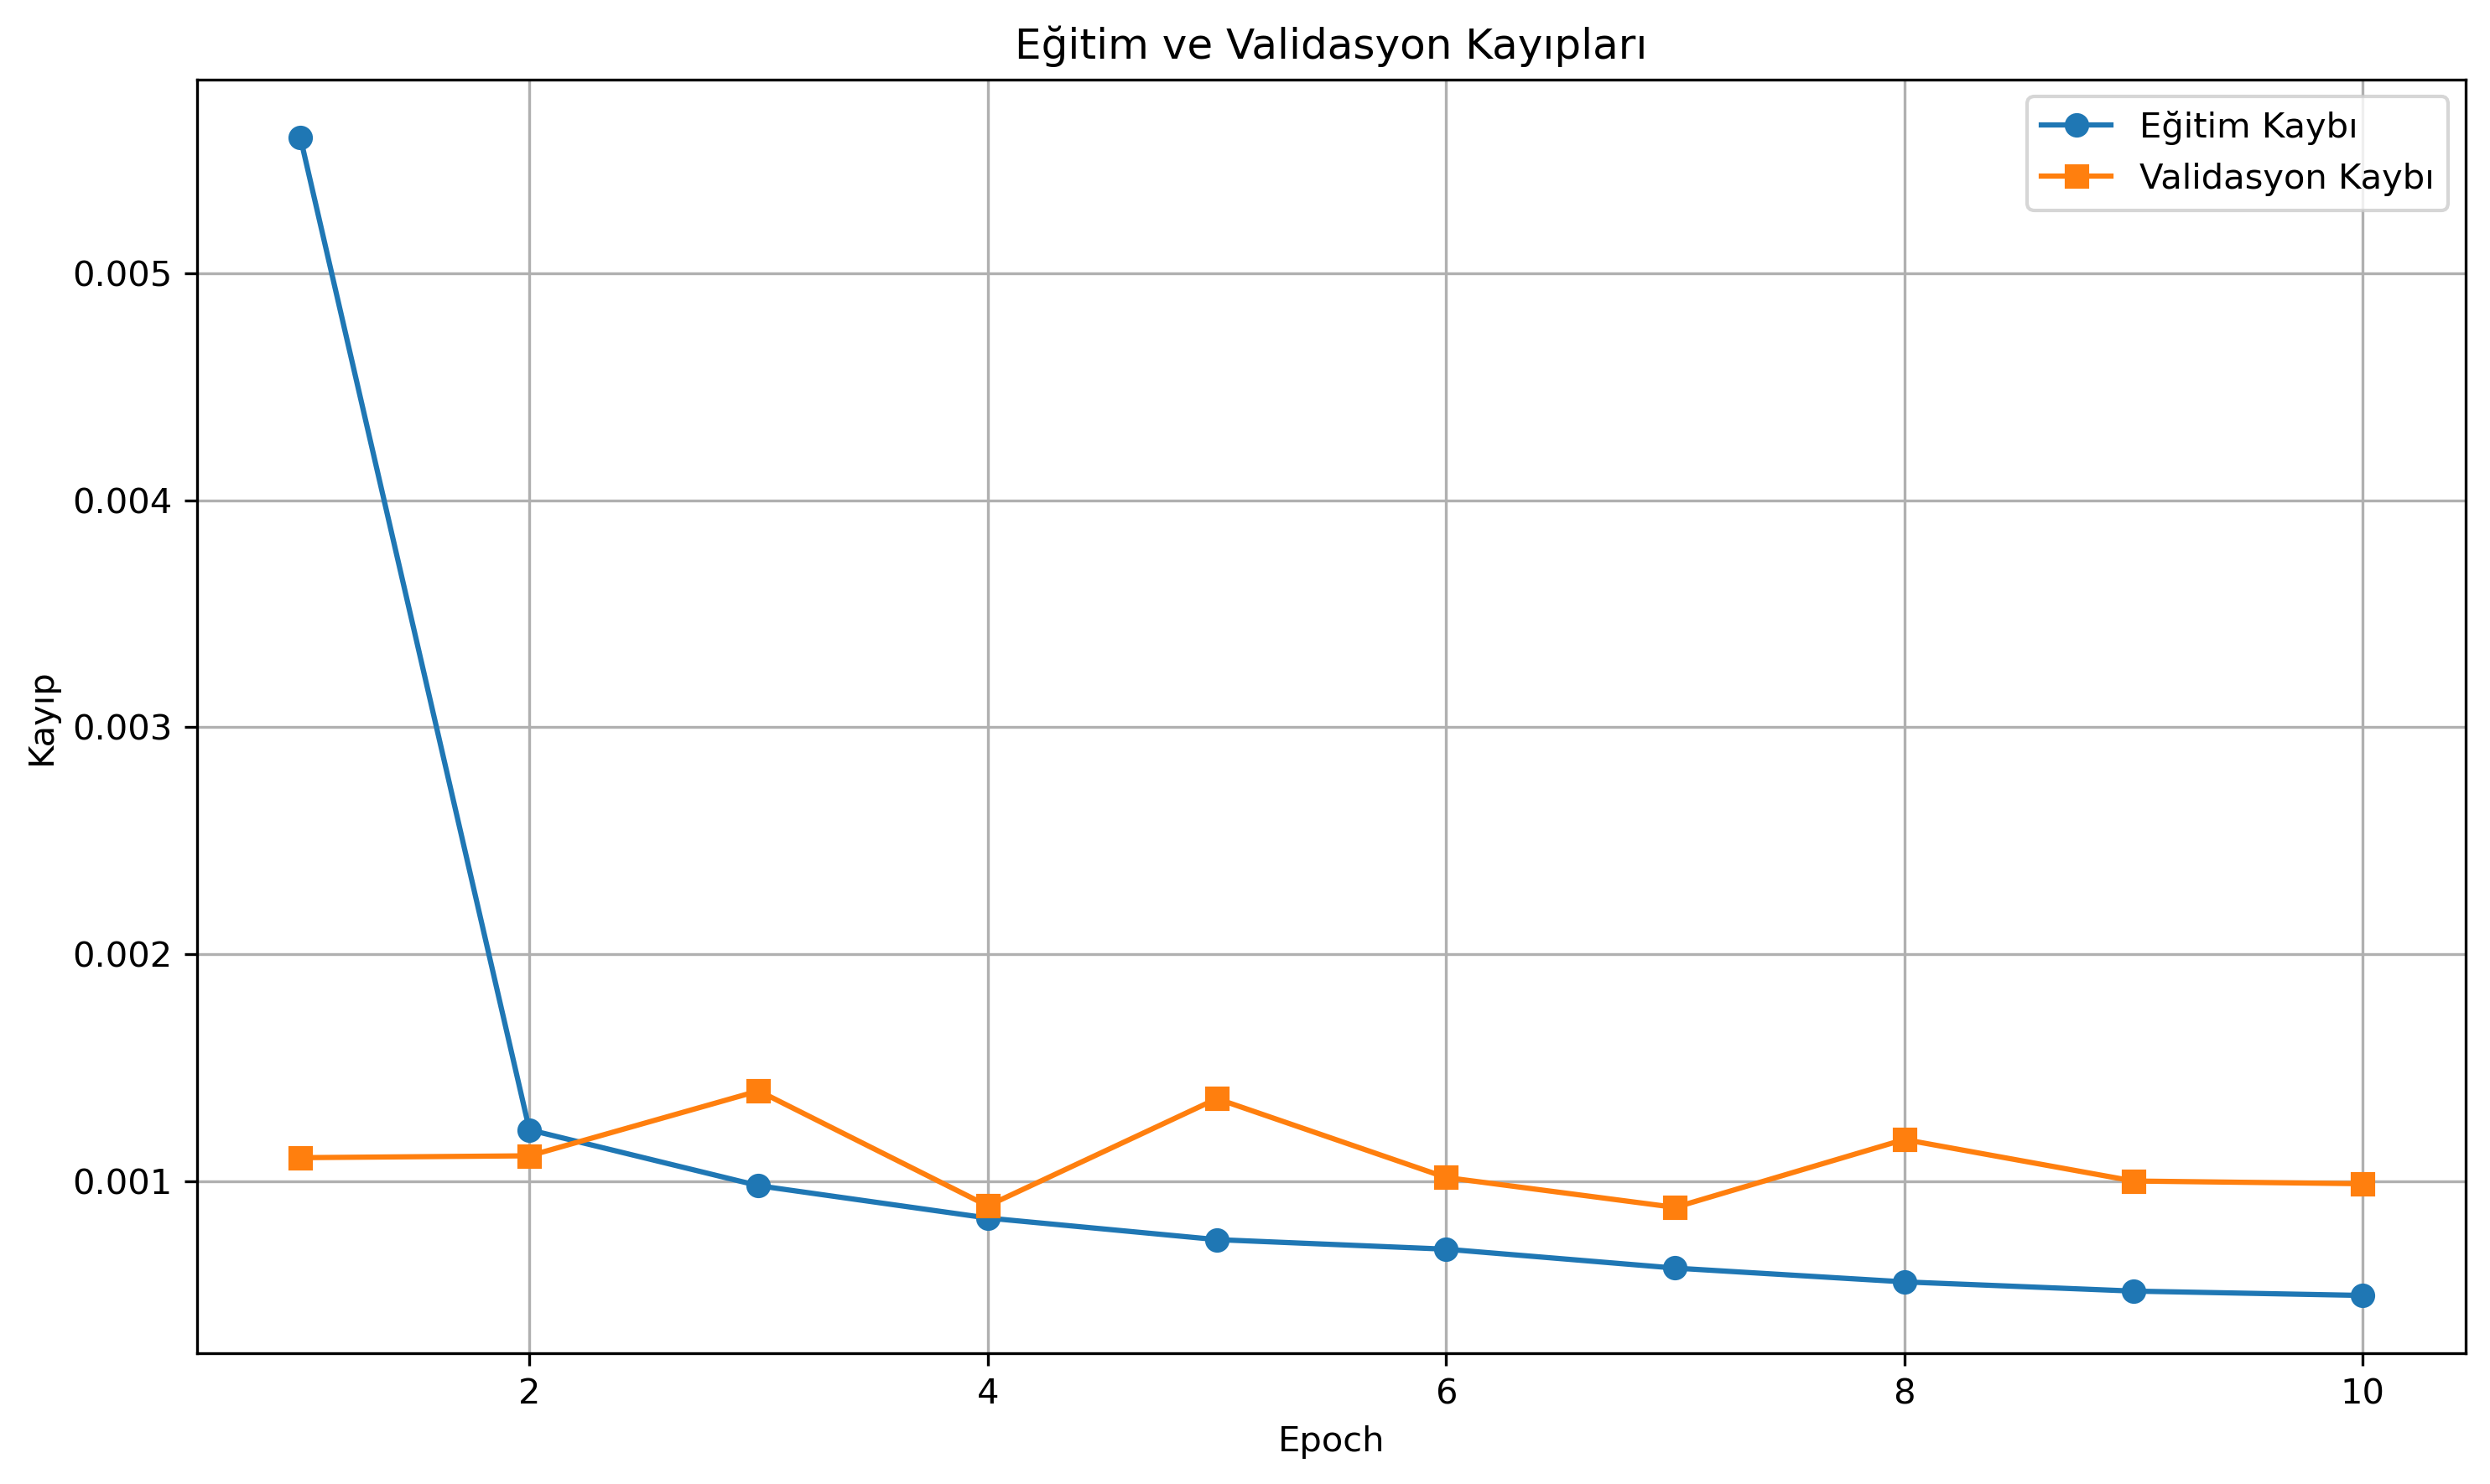

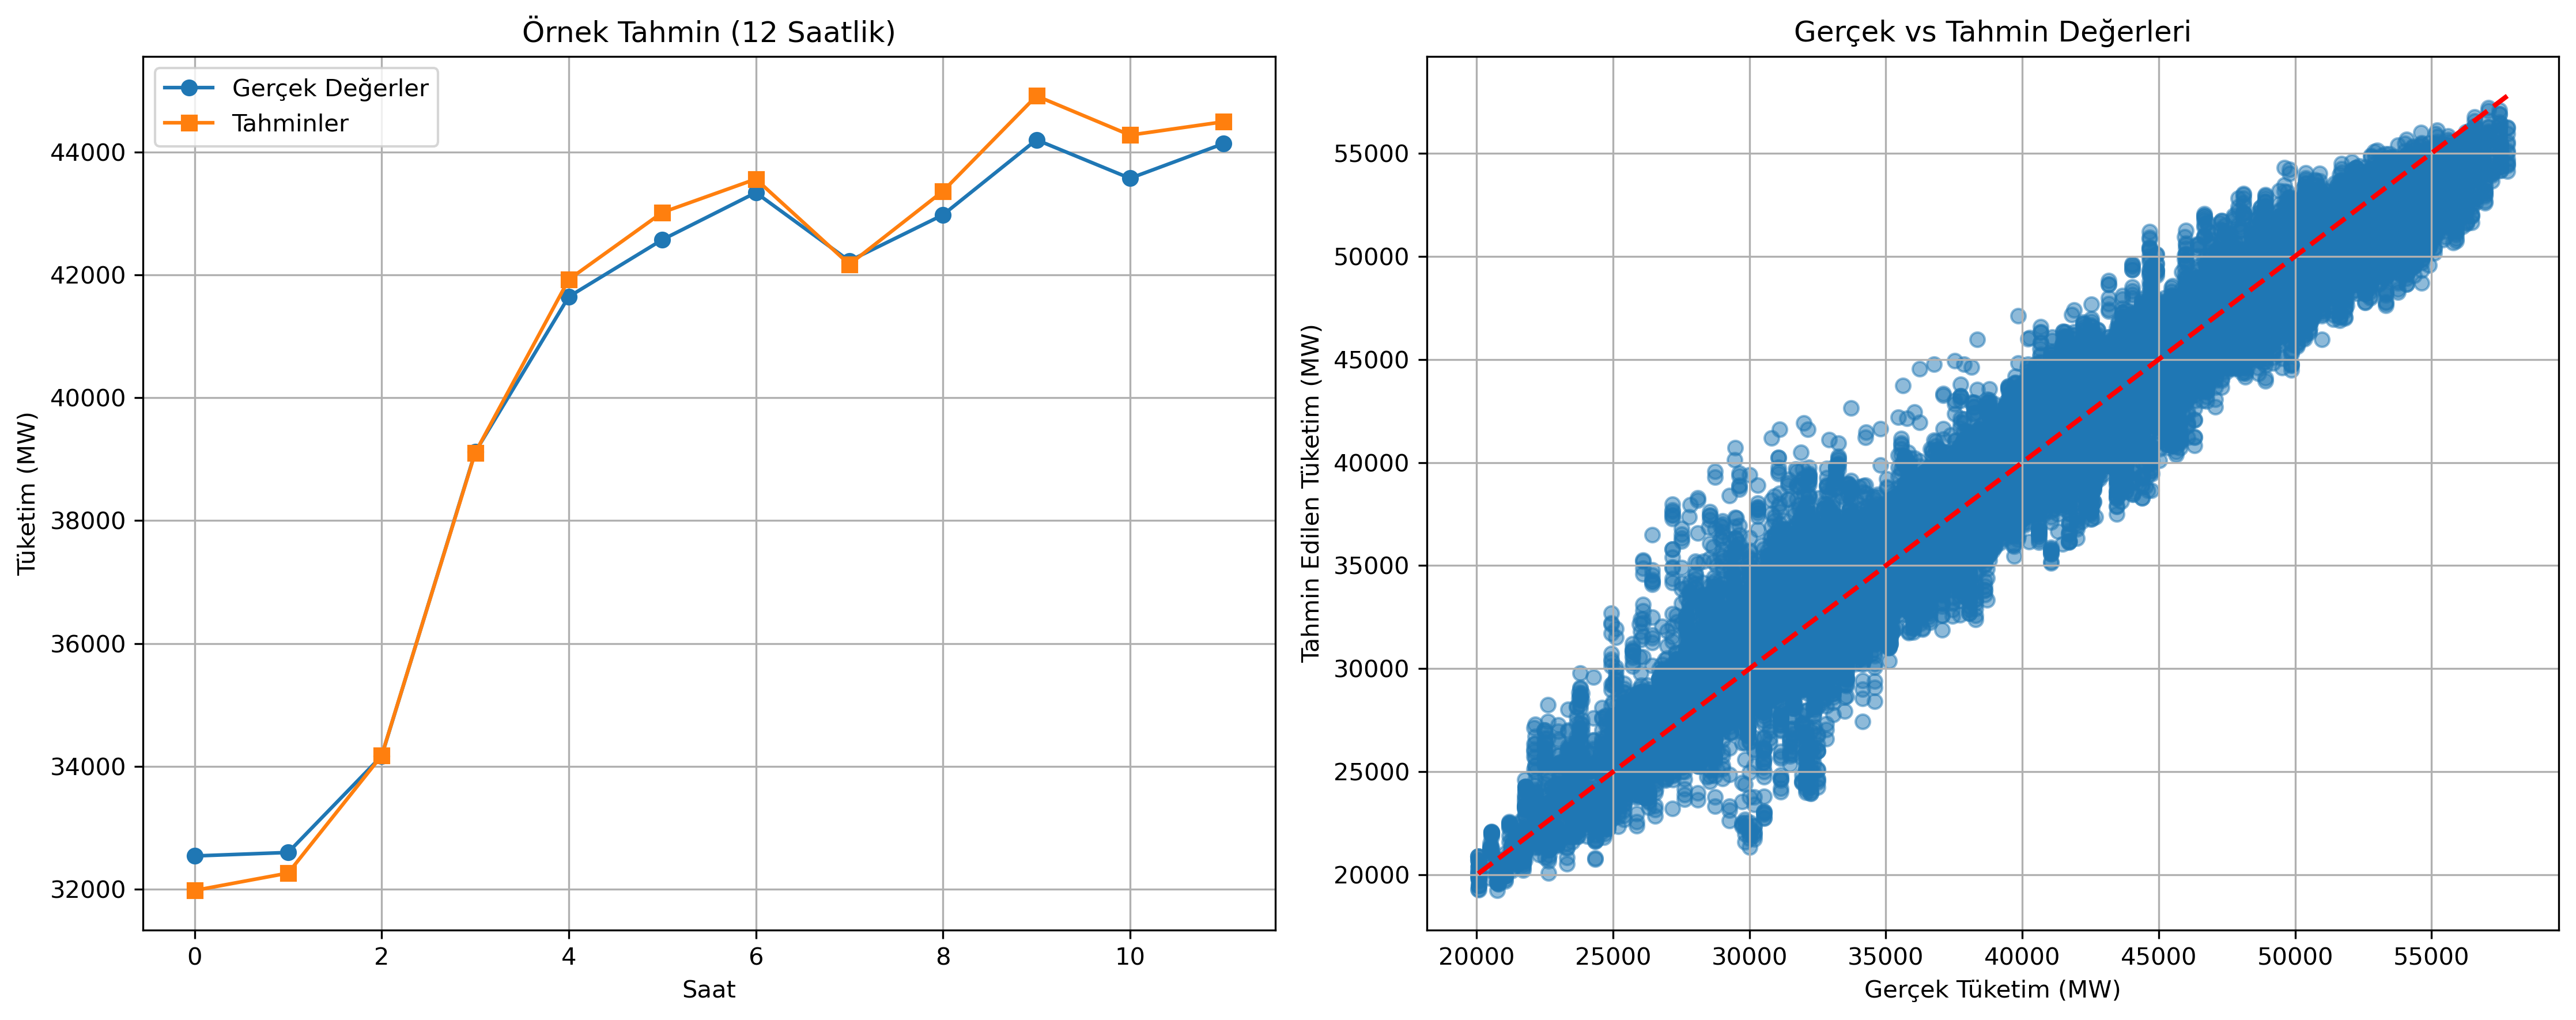


Model Performans Metrikleri:
+----------+----------------+
| Metrik   |          Değer |
+==========+================+
| MSE      |    1.59269e+06 |
+----------+----------------+
| RMSE     | 1262.02        |
+----------+----------------+
| MAE      |  904.646       |
+----------+----------------+
| MAPE     |    2.3938      |
+----------+----------------+
| R2       |    0.9603      |
+----------+----------------+

Model Süre Metrikleri:
+------------------------------------+---------+
| Metrik                             |   Değer |
+====================================+=========+
| Eğitim Süresi (saniye)             |  513.39 |
+------------------------------------+---------+
| Çıkarım Süresi (saniye)            |    2.63 |
+------------------------------------+---------+
| Ortalama Çıkarım Süresi (ms/örnek) |    0.25 |
+------------------------------------+---------+


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from tabulate import tabulate
from torch.optim import lr_scheduler

def load_data(generation_path: str, consumption_path: str) -> pd.DataFrame:
    df_gen = pd.read_csv(generation_path)
    df_cons = pd.read_csv(consumption_path)
    
    df_gen['Tarih'] = pd.to_datetime(df_gen['Tarih'] + ' ' + df_gen['hour'], format='%d.%m.%Y %H:%M')
    df_cons['Tarih'] = pd.to_datetime(df_cons['Tarih'] + ' ' + df_cons['hour'], format='%d.%m.%Y %H:%M')
    
    df = pd.merge(df_gen, df_cons[['Tarih', 'consumption']], on='Tarih', how='inner')
    return df

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['hour'] = df['Tarih'].dt.hour
    df['day'] = df['Tarih'].dt.day
    df['month'] = df['Tarih'].dt.month
    df['day_of_week'] = df['Tarih'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    df['lag_24_gen'] = df['total'].shift(24)
    df['lag_168_gen'] = df['total'].shift(168)
    df['lag_336_gen'] = df['total'].shift(336)
    
    df['rolling_mean_24h_gen'] = df['total'].rolling(window=24).mean()
    df['rolling_mean_168h_gen'] = df['total'].rolling(window=168).mean()
    df['rolling_std_24h_gen'] = df['total'].rolling(window=24).std()
    
    df['trend_24h_gen'] = df['total'].diff(24)
    df['trend_168h_gen'] = df['total'].diff(168)
    
    df = df.bfill()
    df = df.ffill()
    
    return df

def prepare_data_for_fedformer(df: pd.DataFrame, feature_columns: list, seq_len: int = 24, pred_len: int = 12):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X = df[feature_columns].values
    y = df['consumption'].values.reshape(-1, 1)
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    X_sequences = []
    y_sequences = []
    
    for i in range(len(df) - seq_len - pred_len + 1):
        X_sequences.append(X_scaled[i:(i + seq_len)])
        y_sequences.append(y_scaled[(i + seq_len):(i + seq_len + pred_len)])
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    train_size = int(0.8 * len(X_sequences))
    
    X_train = torch.FloatTensor(X_sequences[:train_size])
    y_train = torch.FloatTensor(y_sequences[:train_size])
    X_test = torch.FloatTensor(X_sequences[train_size:])
    y_test = torch.FloatTensor(y_sequences[train_size:])
    
    return (X_train, y_train, X_test, y_test), (scaler_X, scaler_y)

class FourierTransform(nn.Module):
    def __init__(self, in_channels, out_channels, modes=16):
        super().__init__()
        self.modes = modes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.randn(modes, in_channels, out_channels, 2))
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        x_ft = torch.fft.rfft(x, dim=1)
        
        out_ft = torch.zeros(batch_size, x.size(1)//2 + 1, self.out_channels, 
                           device=x.device, dtype=torch.cfloat)
        
        if self.modes > x_ft.shape[1]:
            self.modes = x_ft.shape[1]
        
        for m in range(self.modes):
            x_m = x_ft[:, m:m+1, :]
            w_m = torch.complex(
                self.weights[m, :, :, 0],
                self.weights[m, :, :, 1]
            )
            
            out_ft[:, m:m+1, :] = torch.bmm(
                x_m,
                w_m.unsqueeze(0).expand(batch_size, -1, -1)
            )
        
        x = torch.fft.irfft(out_ft, n=x.size(1), dim=1)
        return x

class FEDformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1, modes=16):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        
        self.fourier = FourierTransform(d_model, d_model, modes=modes)
        
        self.attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        fourier_out = self.fourier(x)
        x = x + self.dropout(fourier_out)
        x = self.norm1(x)
        
        x_t = x.transpose(0, 1)
        attn_out, _ = self.attention(x_t, x_t, x_t)
        x = x + self.dropout(attn_out.transpose(0, 1))
        x = self.norm2(x)
        
        ff_out = self.ff(x)
        x = x + self.dropout(ff_out)
        x = self.norm3(x)
        
        return x

class FEDformer(nn.Module):
    def __init__(self, input_size, d_model=64, n_heads=8, n_layers=3, dropout=0.1, modes=16, pred_len=12):
        super().__init__()
        
        self.pred_len = pred_len
        
        self.input_projection = nn.Linear(input_size, d_model)
        
        self.layers = nn.ModuleList([
            FEDformerBlock(d_model, n_heads, dropout=dropout, modes=modes)
            for _ in range(n_layers)
        ])
        
        self.output_projection = nn.Linear(d_model, pred_len)
    
    def forward(self, x):
        x = self.input_projection(x)
        
        for layer in self.layers:
            x = layer(x)
        
        x = x[:, -1, :]
        
        x = self.output_projection(x)
        
        return x.unsqueeze(-1)

def create_model(input_size, pred_len=12):
    model = FEDformer(
        input_size=input_size,
        d_model=128,
        n_heads=8,
        n_layers=3,
        dropout=0.1,
        modes=16,
        pred_len=pred_len
    )
    return model

def train_model(model, train_loader, test_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    training_start_time = time.time()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
    
    best_val_loss = float('inf')
    best_model = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss/len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss/len(test_loader)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(model)
    
    training_time = time.time() - training_start_time
    
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Eğitim Kaybı', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validasyon Kaybı', marker='s')
    plt.title('Eğitim ve Validasyon Kayıpları')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('fedformer_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return best_model, training_time

def evaluate_model(model, X_test):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    inference_start_time = time.time()
    
    model.eval()
    predictions_list = []
    with torch.no_grad():
        for i in range(0, len(X_test), 32):
            batch_x = X_test[i:i+32].to(device)
            batch_pred = model(batch_x)
            predictions_list.append(batch_pred.cpu())
    
    predictions = torch.cat(predictions_list, dim=0)
    
    inference_time = time.time() - inference_start_time
    
    return predictions, inference_time

def visualize_results(predictions, actuals):
    plt.figure(figsize=(15, 6), dpi=300)
    
    plt.subplot(121)
    plt.plot(actuals[0], label='Gerçek Değerler', marker='o')
    plt.plot(predictions[0], label='Tahminler', marker='s')
    plt.title('Örnek Tahmin (12 Saatlik)')
    plt.xlabel('Saat')
    plt.ylabel('Tüketim (MW)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(122)
    plt.scatter(actuals.reshape(-1), predictions.reshape(-1), alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.title('Gerçek vs Tahmin Değerleri')
    plt.xlabel('Gerçek Tüketim (MW)')
    plt.ylabel('Tahmin Edilen Tüketim (MW)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('fedformer_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    df = load_data('csv_files/realtime_generation_data.csv', 
                   'csv_files/realtime_consumption_data.csv')
    df = create_features(df)
    
    feature_columns = [
        'total', 'hour', 'day_of_week', 'is_weekend',
        'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
        'lag_24_gen', 'lag_168_gen', 'lag_336_gen',
        'rolling_mean_24h_gen', 'rolling_mean_168h_gen', 'rolling_std_24h_gen',
        'trend_24h_gen', 'trend_168h_gen'
    ]
    
    (X_train, y_train, X_test, y_test), (scaler_X, scaler_y) = prepare_data_for_fedformer(df, feature_columns)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
    
    model = create_model(input_size=len(feature_columns))
    best_model, training_time = train_model(model, train_loader, test_loader)
    
    predictions, inference_time = evaluate_model(best_model, X_test)
    
    predictions = predictions.squeeze(-1).numpy()
    actuals = y_test.squeeze(-1).numpy()
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    metrics = {
        'MSE': mean_squared_error(actuals, predictions),
        'RMSE': np.sqrt(mean_squared_error(actuals, predictions)),
        'MAE': mean_absolute_error(actuals, predictions),
        'MAPE': np.mean(np.abs((actuals - predictions) / actuals)) * 100,
        'R2': r2_score(actuals, predictions)
    }
    
    metrics_data = [[key, f"{value:.4f}"] for key, value in metrics.items()]
    metrics_table = tabulate(metrics_data, headers=["Metrik", "Değer"], tablefmt="grid")
    
    timing_data = [
        ["Eğitim Süresi (saniye)", f"{training_time:.2f}"],
        ["Çıkarım Süresi (saniye)", f"{inference_time:.2f}"],
        ["Ortalama Çıkarım Süresi (ms/örnek)", f"{(inference_time * 1000 / len(X_test)):.2f}"]
    ]
    timing_table = tabulate(timing_data, headers=["Metrik", "Değer"], tablefmt="grid")
    
    with open("fedformer_metrics.txt", "w", encoding="utf-8") as f:
        f.write("Model Performans Metrikleri:\n")
        f.write(metrics_table)
        f.write("\n\nModel Süre Metrikleri:\n")
        f.write(timing_table)
    
    visualize_results(predictions, actuals)
    
    print("\nModel Performans Metrikleri:")
    print(metrics_table)
    print("\nModel Süre Metrikleri:")
    print(timing_table)
